In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import string
import time

In [2]:
#Load the data from the csv file and clean it
df = pd.read_csv('data/RealEstate_California.csv')

#### Use the analysis from the 'data_analysis' notebook:
<pre>
 0   sequence            35389 non-null  int64    x   Drop column due to its high uniqueness
 1   id                  35389 non-null  object   x   Drop column due to its high uniqueness
 2   stateId             35389 non-null  int64    x   Drop column since the data is for CA only
 3   countyId            35389 non-null  int64    x   Drop column in favor of zipcode as the location feature
 4   cityId              35389 non-null  int64    x   Drop column in favor of zipcode as the location feature
 5   country             35389 non-null  object   x   Drop column since the data is for only one county (US)
 6   datePostedString    35386 non-null  object   x   Drop all records older than '2021-01-01', then drop this column
 7   is_bankOwned        35389 non-null  int64    x   Drop records where value is 1 then drop this column
 8   is_forAuction       35389 non-null  int64    x   Drop records where value is 1 then drop this column
 9   event               35100 non-null  object   x   Drop records where 'event'='Listing removed' OR 'event'='Listed for rent'
 10  time                35100 non-null  float64  x   Drop column as specific time of listing is not helpful
 11  price               35389 non-null  float64  x   Keep records where price>0 and price <= upper fence ($2,399,870)
 12  pricePerSquareFoot  35389 non-null  float64  x   Drop this column because of a very weak correlation with price
 13  city                35389 non-null  object   x   Drop column in favor of cityId
 14  state               35389 non-null  object   x   Drop column in favor of stateId
 15  yearBuilt           35389 non-null  int64    x   Convert to categorical column
 16  streetAddress       35388 non-null  object   x   Drop column in favor of zipcode as the location feature
 17  zipcode             35364 non-null  float64  x   Convert to categorical column
 18  longitude           35389 non-null  float64  x   Drop column in favor of zipcode as the location feature
 19  latitude            35389 non-null  float64  x   Drop column in favor of zipcode as the location feature
 20  hasBadGeocode       35389 non-null  int64    x   Drop column as it has only one value (0)
 21  description         35110 non-null  object   x   Retain to perform NLP analysis
 22  currency            35389 non-null  object   x   Drop column as all data is in USD
 23  livingArea          35389 non-null  float64  x   Drop column in favor of livingAreaValue
 24  livingAreaValue     35389 non-null  float64  x   Drop records where livingAreaValue=0
 25  lotAreaUnits        35389 non-null  object   x   Retain as-is
 26  bathrooms           35389 non-null  float64  x   Drop records where bathrooms=0
 27  bedrooms            35389 non-null  float64  x   Drop records where bedrooms=0
 28  buildingArea        35389 non-null  float64  x   Drop column since a large majority of values are 0 (almost 15K)
 29  parking             35389 non-null  int64    x   Convert to bool column
 30  garageSpaces        35389 non-null  float64  x   Retain as-is
 31  hasGarage           35389 non-null  int64    x   Convert to bool column
 32  levels              35389 non-null  object   x   see detailed comment below
 33  pool                35389 non-null  int64    x   Convert to bool column
 34  spa                 35389 non-null  int64    x   Convert to bool column
 35  isNewConstruction   35389 non-null  int64    x   Drop records where isNewConstruction=1, drop the column
 36  hasPetsAllowed      35389 non-null  int64    x   Drop column since single family homes usually do not have such restriction
 37  homeType            35389 non-null  object   x   Retain records where 'homeType'='SINGLE_FAMILY' and then drop this column 
 38  county              35389 non-null  object   x   Drop column in favor of zipcode as the location feature
 </pre>

Update the values in the 'levels' such that:
- '0', '1', 'One Story', 'One Story-One' = 'One'
- '2', 'Two Story', 'Two Story-One', 'Two Story-Two',  'Two-One' = 'Two'
- '3', '4+', 'Three', 'Three Or More', 'Multi/Split-One', 'Multi/Split-Three Or More', 'Multi/Split-Tri-Level', 'Multi/Split-Two, 'One-Multi/Split', 'One-Three Or More', 'One-Two', 'One-Two-Multi/Split', 'One-Two-Three Or More', 'Split Level', 'Three Or More-Multi/Split', 'Three Or More-Two', 'Three or More Stories', 'Three or More Stories-One-Two', 'Three or More Stories-Three Or More', 'Tri-Level',  'Two-Multi/Split', 'Two-Three Or More' = 'Multi/Split'


In [3]:
# Using the analysis from the EDA, we can clean the data as follows:
#1: Start with cleaning up the records:

#Drop all records older than '2021-01-01', then drop this column
df = df.loc[df['datePostedString'] >= '2021-01-01']
df.drop('datePostedString', axis=1, inplace=True)

#Drop records where value is 1 then drop this column
df = df.loc[df['is_bankOwned'] == 0]
df.drop('is_bankOwned', axis=1, inplace=True)

#Drop records where value is 1 then drop this column
df = df.loc[df['is_forAuction'] == 0]
df.drop('is_forAuction', axis=1, inplace=True)

#Dop records where value is 1 then drop this column
df = df.loc[df['isNewConstruction'] == 0]
df.drop('isNewConstruction', axis=1, inplace=True)

#Drop records where 'event'='Listing removed' OR 'event'='Listed for rent'
df = df.loc[(df['event'] != 'Listing removed') & (df['event'] != 'Listed for rent')]

#Drop records where bathrooms=0
df = df.loc[df['bathrooms'] > 0]

#Drop records where bedrooms=0
df = df.loc[df['bedrooms'] > 0]

#Drop records where livingAreaValue=0
df = df.loc[df['livingAreaValue'] > 0]

#Drop records where price=0
df = df[(df['price'] > 0) & (df['price'] <= 2_399_870)] #price_upper_fence

#Retain records where 'homeType'='SINGLE_FAMILY' and then drop this column 
df = df.loc[df['homeType'] == 'SINGLE_FAMILY']
df.drop('homeType', axis=1, inplace=True)

#Drop the records with missing description
#df = df.dropna(subset=['description'])

#2: Drop the columns:
# sequence, id, countyId, cityId, stateId, country, time, pricePerSquareFoot, city, state, streetAddress, longitude, latitude, hasBadGeocode, description, currency, livingArea, lotAreaUnits, buildingArea, county, hasPetsAllowed         
df.drop(['sequence', 'id', 'countyId', 'cityId', 'stateId', 'country', 'time', 'pricePerSquareFoot', 'city', 'state', 'streetAddress', 'longitude', 'latitude', 'hasBadGeocode', 'currency', 'livingArea', 'buildingArea', 'county', 'hasPetsAllowed'], axis=1, inplace=True)

#3: Convert these columns to categorical columns: yearBuilt, zipcode
df['yearBuilt'] = df['yearBuilt'].astype('object')

#4: Convert the zipcode to integer value first (from float) then convert to object
df['zipcode'] = df['zipcode'].astype(int)
df['zipcode'] = df['zipcode'].astype('object')

#5: Convert columns to boolean (True/False) instead of 1, 0 for 'parking', 'pool', 'spa', 'hasGarage'
# Ensure columns are initially of integer type (0/1)
df['parking'] = df['parking'].astype(int)
df['pool'] = df['pool'].astype(int)
df['spa'] = df['spa'].astype(int)
df['hasGarage'] = df['hasGarage'].astype(int)


# Convert integer columns to boolean (True/False)
df['parking'] = df['parking'].astype(bool)
df['pool'] = df['pool'].astype(bool)
df['spa'] = df['spa'].astype(bool)
df['hasGarage'] = df['hasGarage'].astype(bool)

#6: Update the values in the 'levels' column such that:
# - '0', '1', 'One Story', 'One Story-One' = 'One'
# - '2', 'Two Story', 'Two Story-One', 'Two Story-Two',  'Two-One' = 'Two'
# - '3', '4+', 'Three', 'Three Or More', 'Multi/Split-One', 'Multi/Split-Three Or More', 'Multi/Split-Tri-Level', 'Multi/Split-Two, 'One-Multi/Split', 'One-Three Or More', 'One-Two', 'One-Two-Multi/Split', 'One-Two-Three Or More', 'Split Level', 'Three Or More-Multi/Split', 'Three Or More-Two', 'Three or More Stories', 'Three or More Stories-One-Two', 'Three or More Stories-Three Or More', 'Tri-Level',  'Two-Multi/Split', 'Two-Three Or More' = 'Multi/Split'
df['levels'] = df['levels'].replace(['0', '1', 'One Story', 'One Story-One'], 'One') #assuming '0' means 'One' for single story houses
df['levels'] = df['levels'].replace(['2', 'Two Story', 'Two Story-One', 'Two Story-Two', 'Two-One'], 'Two')
df['levels'] = df['levels'].replace(['3', '4+', 'Three', 'Three Or More', 'Multi/Split-One', 'Multi/Split-Three Or More', 'Multi/Split-Tri-Level', 'Multi/Split-Two', 'One-Multi/Split', 'One-Three Or More', 'One-Two', 'One-Two-Multi/Split', 'One-Two-Three Or More', 'Split Level', 'Three Or More-Multi/Split', 'Three Or More-Two', 'Three or More Stories', 'Three or More Stories-One-Two', 'Three or More Stories-Three Or More', 'Tri-Level',  'Two-Multi/Split', 'Two-Three Or More'], 'Multi/Split')

df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17807 entries, 0 to 17806
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   event            17807 non-null  object 
 1   price            17807 non-null  float64
 2   yearBuilt        17807 non-null  object 
 3   zipcode          17807 non-null  object 
 4   description      17710 non-null  object 
 5   livingAreaValue  17807 non-null  float64
 6   lotAreaUnits     17807 non-null  object 
 7   bathrooms        17807 non-null  float64
 8   bedrooms         17807 non-null  float64
 9   parking          17807 non-null  bool   
 10  garageSpaces     17807 non-null  float64
 11  hasGarage        17807 non-null  bool   
 12  levels           17807 non-null  object 
 13  pool             17807 non-null  bool   
 14  spa              17807 non-null  bool   
dtypes: bool(4), float64(5), object(6)
memory usage: 1.6+ MB


In [4]:
df.isnull().sum()

event               0
price               0
yearBuilt           0
zipcode             0
description        97
livingAreaValue     0
lotAreaUnits        0
bathrooms           0
bedrooms            0
parking             0
garageSpaces        0
hasGarage           0
levels              0
pool                0
spa                 0
dtype: int64

## Feature Engineering

Feature engineering can significantly boost the performance of the housing price prediction model. 

#### NLP based processing of description field

I will extract the keywords listed and create these as categorical columns' with values

In [5]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')

# Define the keyword categories for homes
keyword_categories = {
    "Features": ['master', 'detached', 'waterfront', 'bonus room', 'solar panel', 'office', 'guest house', 'in law', 'granite', 'new roof', 'custom landscape', 'custom closet', 'backyard', 'back yard'],
    "Property_Condition": ['remodeled', 'renovated', 'designer', 'fixer upper', 'TLC', 'handyman special', 'model home'],
    "Location_Neighborhood": ['safe', 'cul de sac', 'gated', 'freeway', 'highway', 'golf course', 'beach', 'school', 'view', 'acre', 'secure', 'airport', 'train'],
    "Property_Style_Layout": ['ranch', 'colonial', 'victorian', 'mediterranean', 'contemporary', 'modern', 'tuscan', 'farmhouse'],
    "Amenities": ['pet', 'bar', 'pergola', 'furnished', 'community pool', 'gym', 'fireplace', 'deck'],
    "Terms": ['short sale', 'foreclosure', 'owner financing', 'seller financing', 'seller credit', 'cash offer', 'deed', 'association fee', 'motivated']
}

# Initialize the PorterStemmer and WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Create new columns based on keyword categories
for category, keywords in keyword_categories.items():
    # Create the column outside the inner loop
    for keyword in keywords:
        # Stem the keyword
        stemmed_keyword = stemmer.stem(keyword)
        
        # Lemmatize the stemmed keyword
        final_keyword = lemmatizer.lemmatize(stemmed_keyword)
        
        # Create a new column for the final keyword
        df[final_keyword.replace(' ', '_')] = 0  # Initialize column with 0
    
    # Iterate over rows and count occurrences of each keyword
    for i in range(len(df)):
        description = df.loc[i, 'description']
        
        # Check if description is a string, if not, convert to string or use empty string
        if not isinstance(description, str):
            if pd.isna(description):
                description = ''
            else:
                description = str(description)
        
        for keyword in keywords:
            # Stem the keyword
            stemmed_keyword = stemmer.stem(keyword)
            
            # Lemmatize the stemmed keyword
            final_keyword = lemmatizer.lemmatize(stemmed_keyword)
            
            df.loc[i, final_keyword.replace(' ', '_')] = len([token for token in word_tokenize(description.lower().translate(str.maketrans('', '', string.punctuation))) if token.lower() == final_keyword.lower()])



In [6]:
#print the df column names other than the ones starting with zipcode_ or description_
print(df.columns[~df.columns.str.startswith('zipcode_') & ~df.columns.str.startswith('description_')])

#print the number of columns
print(len(df.columns))

Index(['event', 'price', 'yearBuilt', 'zipcode', 'description',
       'livingAreaValue', 'lotAreaUnits', 'bathrooms', 'bedrooms', 'parking',
       'garageSpaces', 'hasGarage', 'levels', 'pool', 'spa', 'master',
       'detach', 'waterfront', 'bonus_room', 'solar_panel', 'offic',
       'guest_hous', 'in_law', 'granit', 'new_roof', 'custom_landscap',
       'custom_closet', 'backyard', 'back_yard', 'remodel', 'renov', 'design',
       'fixer_upp', 'tlc', 'handyman_speci', 'model_hom', 'safe', 'cul_de_sac',
       'gate', 'freeway', 'highway', 'golf_cours', 'beach', 'school', 'view',
       'acr', 'secur', 'airport', 'train', 'ranch', 'coloni', 'victorian',
       'mediterranean', 'contemporari', 'modern', 'tuscan', 'farmhous', 'pet',
       'bar', 'pergola', 'furnish', 'community_pool', 'gym', 'fireplac',
       'deck', 'short_sal', 'foreclosur', 'owner_financ', 'seller_financ',
       'seller_credit', 'cash_off', 'deed', 'association_fe', 'motiv'],
      dtype='object')
74


In [7]:
#create a copy of df for later usage
df_copy = df.copy() #use a checkpoint for restoring the df dataframe

In [8]:
#restore the df from the checkpoint
df = df_copy.copy()

##### Derived Features from Existing Data:
1. Age of the House: Calculate the age of the house by subtracting the year built from the current year (or a reference year=2021).
2. Living Area per Room: Divide the living area by the number of rooms to get a measure of space per room (sum of number of bedrooms and bathrooms).
3. Bath to Bedroom Ratio: bathrooms / bedrooms
4. Garage to Bedroom Ratio: garageSpaces / bedrooms

In [9]:
# Feature Engineering - Derived Features (as before)
df['AgeOfHouse'] = 2021 - pd.to_numeric(df['yearBuilt'])
# df['NumRooms'] = df['bedrooms'] + df['bathrooms']
# df['LivingAreaPerRoom'] = df['livingAreaValue'] / df['NumRooms']
df['LivingAreaPerRoom'] = df['livingAreaValue'] / (df['bedrooms'] + df['bathrooms'])
df['BathToBedroomRatio'] = df['bathrooms'] / df['bedrooms']
df['GarageToBedroomRatio'] = df['garageSpaces'] / df['bedrooms']

# Drop unnecessary columns
df = df.drop(['yearBuilt', 'livingAreaValue'], axis=1) # Drop the original columns since they are better represented by the derived features

#### Perform one hot encoding for categorical columns

In [10]:
print(df.select_dtypes(include=['object', 'bool']).columns)

Index(['event', 'zipcode', 'description', 'lotAreaUnits', 'parking',
       'hasGarage', 'levels', 'pool', 'spa'],
      dtype='object')


In [11]:
# Perform One-Hot Encoding for Object Columns
object_cols = df.select_dtypes(include=['object']).columns #bool columns don't need encoding
enc = OneHotEncoder(handle_unknown='ignore')
encoded_data = enc.fit_transform(df[object_cols]).toarray()

# Get the feature names using input features and format with underscores
feature_names = enc.get_feature_names_out(input_features=object_cols)
feature_names = [name.replace(' ', '_') for name in feature_names]  # Replace spaces with underscores

encoded_df = pd.DataFrame(encoded_data, columns=feature_names)

# Drop the original object columns
df = df.drop(object_cols, axis=1)

# Scale features before splitting
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['number'])
numeric_data = df.drop('price', axis=1)
scaled_data = scaler.fit_transform(numeric_data) 

#remove the 'price' column from df.columns (not from df) series before creating the scaled_df
df_columns_no_price = df.columns.drop('price')
scaled_df = pd.DataFrame(scaled_data, columns=df_columns_no_price)


# Concatenate scaled_df and encoded_df (using pandas)
#df_ohe = pd.concat([df, encoded_df], axis=1)
df_ohe_scaled = pd.concat([scaled_df, encoded_df], axis=1)
df_ohe_scaled['price'] = df['price']


##### Analyze the distribution of keywords in the 'description' field

/var/folders/tj/c62qxbyn3n5gnsb1w1_jq4vw0000gp/T/ipykernel_70293/3889121531.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keyword_counts[14:34], y=keyword_counts[14:34].index, palette='viridis')


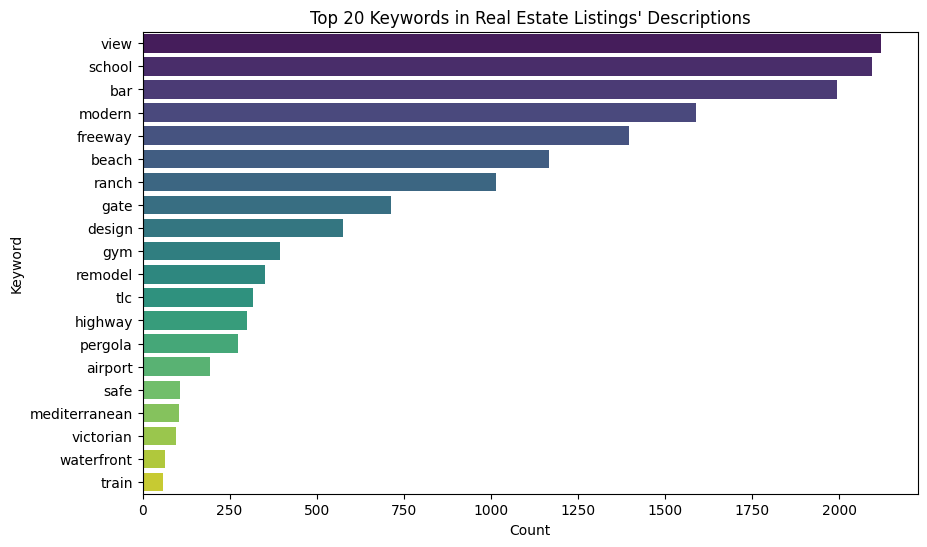

In [12]:
# Analyze the distribution of keywords
keyword_counts = df.drop('price', axis=1).sum()  # Count occurrences of each keyword
keyword_counts = keyword_counts.sort_values(ascending=False)
#Plot for the top keywords excluding the first few which are the derived features
plt.figure(figsize=(10, 6))
sns.barplot(x=keyword_counts[14:34], y=keyword_counts[14:34].index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Top 20 Keywords in Real Estate Listings\' Descriptions')
plt.show()


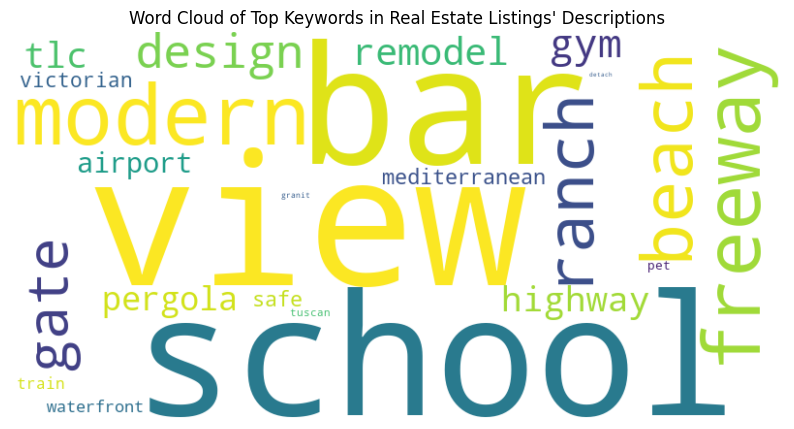

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# 4. Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts[14:38]) 
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top Keywords in Real Estate Listings\' Descriptions')
plt.show()

# Model analysis

### Test out different modeling techniques and identify which one can provide the best predictions

In [14]:
import time
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

import shap  # Import SHAP


2024-07-31 01:08:14.136476: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
#Split the data into training and testing sets
X = df_ohe_scaled.drop('price', axis=1)
X = X.loc[:, ~X.columns.str.startswith('description_')] # Drop the description columns

y = df_ohe_scaled['price']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
#print out all the columns in the dataframe - X_train, excluding the ones starting with 'zipcode_'
print(X_train.columns[~X_train.columns.str.startswith('zipcode_')])

# provide a total count of the columns in the dataframe - X_train
print(len(X_train.columns))

Index(['bathrooms', 'bedrooms', 'parking', 'garageSpaces', 'hasGarage', 'pool',
       'spa', 'master', 'detach', 'waterfront', 'bonus_room', 'solar_panel',
       'offic', 'guest_hous', 'in_law', 'granit', 'new_roof',
       'custom_landscap', 'custom_closet', 'backyard', 'back_yard', 'remodel',
       'renov', 'design', 'fixer_upp', 'tlc', 'handyman_speci', 'model_hom',
       'safe', 'cul_de_sac', 'gate', 'freeway', 'highway', 'golf_cours',
       'beach', 'school', 'view', 'acr', 'secur', 'airport', 'train', 'ranch',
       'coloni', 'victorian', 'mediterranean', 'contemporari', 'modern',
       'tuscan', 'farmhous', 'pet', 'bar', 'pergola', 'furnish',
       'community_pool', 'gym', 'fireplac', 'deck', 'short_sal', 'foreclosur',
       'owner_financ', 'seller_financ', 'seller_credit', 'cash_off', 'deed',
       'association_fe', 'motiv', 'AgeOfHouse', 'LivingAreaPerRoom',
       'BathToBedroomRatio', 'GarageToBedroomRatio', 'event_Listed_for_sale',
       'event_Price_change', 'ev

In [ ]:
# #Function to train and evaluate the model

# def train_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test):
#     """Trains a model using GridSearchCV (for non-NN models) or directly fits (for NN) and evaluates its performance."""

#     if isinstance(model, (Ridge, Lasso, GradientBoostingRegressor)):
#         grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
#         # print the model name
#         grid_search.fit(X_train, y_train)

#         # Evaluate model performance
#         best_params = grid_search.best_params_
#         best_estimator = grid_search.best_estimator_
        
#         # Predict on train and test sets
#         y_pred_train = best_estimator.predict(X_train)
#         y_pred_test = best_estimator.predict(X_test)
        
#         rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
#         rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
#         r2_train = r2_score(y_train, y_pred_train)
#         r2_test = r2_score(y_test, y_pred_test)
        
#         fit_time = grid_search.refit_time_

#         # Calculate feature importance
#         if isinstance(best_estimator, (Ridge, Lasso)):
#             feature_importance = np.abs(best_estimator.coef_)
#         elif isinstance(best_estimator, GradientBoostingRegressor):
#             feature_importance = best_estimator.feature_importances_

#         return best_estimator, rmse_train, rmse_test, r2_train, r2_test, fit_time, feature_importance

#     elif isinstance(model, tf.keras.Model):
#         model = Sequential([
#             Input(shape=(X_train.shape[1],)), 
#             Dense(16, activation='relu'),
#             Dense(16, activation='relu'),
#             Dense(16, activation='relu'),
#             Dense(1)
#         ])

#         # Compile the model
#         optimizer = Adam(learning_rate=0.001) #0.005) #0.0001)

#         model.compile(optimizer=optimizer, 
#                       metrics=[RootMeanSquaredError(), 'r2_score'], 
#                       loss='mse'
#                       )

#         # Fit the model
#         np.random.seed(42)
#         start_time = time.time()
#         history = model.fit(X_train, y_train, epochs=300, verbose=1) # Adjust epochs as needed
#         end_time = time.time()
#         fit_time = end_time - start_time

#         # Evaluate the model
#         y_pred_train = model.predict(X_train)
#         y_pred_test = model.predict(X_test)

#         rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
#         rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
#         r2_train = r2_score(y_train, y_pred_train)
#         r2_test = r2_score(y_test, y_pred_test)

#         # For neural networks, feature importance is not directly available
#         feature_importance = None

#         return model, rmse_train, rmse_test, r2_train, r2_test, fit_time, feature_importance


In [ ]:
# # Define parameter grids

# gradient_boosting_params = {
#     'alpha': [0.01, 0.05],
#     'n_estimators': [500, 1000],
#     'learning_rate': [0.1, 0.2],
#     'random_state': [42],
#     'warm_start': [False]
# }
# ridge_params = {
#     'alpha': [0.5, 1.0],
#     'random_state': [42]
# }
# lasso_params = {
#     'alpha': [1.0, 5.0],
#     'random_state': [42]
# }

# best_rmse_test = float('inf') # Initialize with a very large value
# best_model = None

# # Train and evaluate each model (except LinearRegression)
# models = [
#     (GradientBoostingRegressor(), gradient_boosting_params),
#     (Lasso(), lasso_params),
#     (tf.keras.Model(), None),
#     (Ridge(), ridge_params)
# ]

# results = {}
# for model, params in models:
#     model_name = model.__class__.__name__
#     if model_name == 'Model':
#         model_name = 'Neural Network'
#     best_estimator, rmse_train, rmse_test, r2_train, r2_test, fit_time, feature_importance = train_and_evaluate_model(model, params, X_train, y_train, X_test, y_test)
#     results[model_name] = (best_estimator, rmse_train, rmse_test, r2_train, r2_test, fit_time)

#     # Store the best model based on test RMSE
#     if rmse_test < best_rmse_test:
#         best_rmse_test = rmse_test
#         best_model = best_estimator

#     print (f"Model: {model_name}")
#     print(f"Best Parameters: {best_estimator.get_params() if hasattr(best_estimator, 'get_params') else 'N/A'}")
#     print(f"RMSE (Train): {rmse_train:.4f}")
#     print(f"R-squared (Train): {r2_train:.4f}")
#     print(f"RMSE (Test): {rmse_test:.4f}")
#     print(f"R-squared (Test): {r2_test:.4f}")
#     print(f"Fit Time: {fit_time:.4f} seconds")
    
#     print('Feature importance:')
#     if feature_importance is not None:
#         for i, importance in enumerate(feature_importance):
#             print(f"Feature {i+1} importance: {importance}")
#     else:
#         print("Feature importance not available for this model.")
#     print('Done with the model!')
#     print()



In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
import time
import pandas as pd

def train_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test, feature_names):
    """Trains a model using GridSearchCV (for non-NN models) or directly fits (for NN) and evaluates its performance."""

    if isinstance(model, (Ridge, Lasso, GradientBoostingRegressor)):
        grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        best_estimator = grid_search.best_estimator_
        
        y_pred_train = best_estimator.predict(X_train)
        y_pred_test = best_estimator.predict(X_test)
        
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        
        fit_time = grid_search.refit_time_

        # Calculate feature importance
        if isinstance(best_estimator, (Ridge, Lasso)):
            feature_importance = np.abs(best_estimator.coef_)
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': feature_importance
            }).sort_values('Importance', ascending=False)
        else:
            feature_importance_df = None

        return best_estimator, rmse_train, rmse_test, r2_train, r2_test, fit_time, feature_importance_df

    elif isinstance(model, tf.keras.Model):
        model = Sequential([
            Input(shape=(X_train.shape[1],)), 
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1)
        ])

        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, 
                      metrics=[RootMeanSquaredError(), 'r2_score'], 
                      loss='mse')

        np.random.seed(42)
        start_time = time.time()
        history = model.fit(X_train, y_train, epochs=300, verbose=1)
        end_time = time.time()
        fit_time = end_time - start_time

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)

        feature_importance_df = None

        return model, rmse_train, rmse_test, r2_train, r2_test, fit_time, feature_importance_df

# Define parameter grids
gradient_boosting_params = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3, 5],
    'n_iter_no_change': [5],
    'validation_fraction': [0.2], 
    'random_state': [42]
}
ridge_params = {
    'alpha': [0.5, 1.0],
    'random_state': [42]
}
lasso_params = {
    'alpha': [1.0, 5.0],
    'random_state': [42]
}

best_rmse_test = float('inf')
best_model = None

# Train and evaluate each model
models = [
    (GradientBoostingRegressor(), gradient_boosting_params),
    (Lasso(), lasso_params),
    (tf.keras.Model(), None),
    (Ridge(), ridge_params)
]

# Assuming X_train is a DataFrame, we can get feature names from it
feature_names = X_train.columns.tolist()

results = {}
for model, params in models:
    model_name = model.__class__.__name__
    if model_name == 'Model':
        model_name = 'Neural Network'
    best_estimator, rmse_train, rmse_test, r2_train, r2_test, fit_time, feature_importance_df = train_and_evaluate_model(model, params, X_train, y_train, X_test, y_test, feature_names)
    results[model_name] = (best_estimator, rmse_train, rmse_test, r2_train, r2_test, fit_time)

    if rmse_test < best_rmse_test:
        best_rmse_test = rmse_test
        best_model = best_estimator

    print(f"Model: {model_name}")
    print(f"Best Parameters: {best_estimator.get_params() if hasattr(best_estimator, 'get_params') else 'N/A'}")
    print(f"RMSE (Train): {rmse_train:.4f}")
    print(f"R-squared (Train): {r2_train:.4f}")
    print(f"RMSE (Test): {rmse_test:.4f}")
    print(f"R-squared (Test): {r2_test:.4f}")
    print(f"Fit Time: {fit_time:.4f} seconds")
    
    print('Feature importance:')
    if feature_importance_df is not None:
        print(feature_importance_df)
    else:
        print("Feature importance not available for this model.")
    print('Done with the model!')
    print()

Model: GradientBoostingRegressor
Best Parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': 5, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.2, 'verbose': 0, 'warm_start': False}
RMSE (Train): 313070.4075
R-squared (Train): 0.5656
RMSE (Test): 338684.4091
R-squared (Test): 0.5071
Fit Time: 132.8402 seconds
Feature importance:
Feature importance not available for this model.
Done with the model!



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.107e+12, tolerance: 2.588e+11
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.381e+13, tolerance: 2.573e+11
  model = cd_fast.enet_coordinate_descent(


Model: Lasso
Best Parameters: {'alpha': 5.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
RMSE (Train): 192422.0905
R-squared (Train): 0.8359
RMSE (Test): 223940.8660
R-squared (Test): 0.7845
Fit Time: 4.6979 seconds
Feature importance:
            Feature    Importance
130   zipcode_90211  1.576195e+06
899   zipcode_94301  1.571367e+06
863   zipcode_94024  1.569089e+06
149   zipcode_90266  1.482518e+06
1037  zipcode_95014  1.436302e+06
...             ...           ...
214   zipcode_90805  0.000000e+00
213   zipcode_90804  0.000000e+00
1305  zipcode_95669  0.000000e+00
1307  zipcode_95672  0.000000e+00
1499     levels_Two  0.000000e+00

[1500 rows x 2 columns]
Done with the model!

Epoch 1/300
446/446 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 907810373632.0000 - r2_score: -3.0499 - root_mean_squared_error: 952761.1875
Epoch 2/300
446/446 ━━━━━━━━━━━━━━━━━━━

## SHAP Feature Analysis

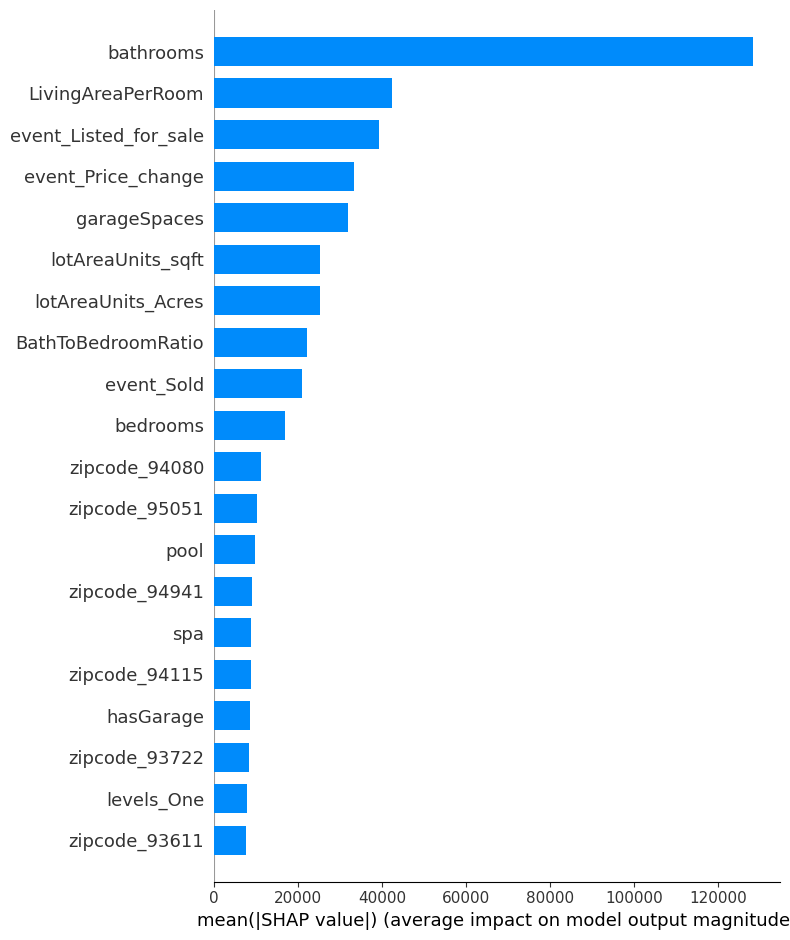

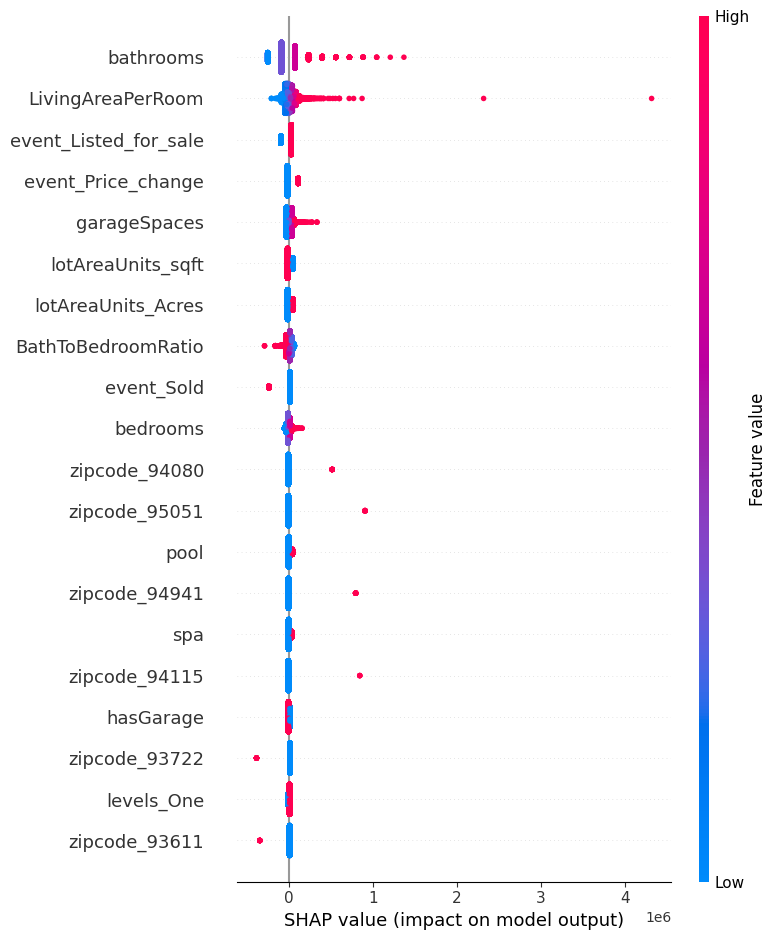

Feature Importance:
                    Feature     Importance
0                 bathrooms  128255.662613
1         LivingAreaPerRoom   42365.346779
2     event_Listed_for_sale   39260.450993
3        event_Price_change   33241.332212
4              garageSpaces   31936.837656
...                     ...            ...
1495          zipcode_94514       0.000000
1496              model_hom       0.000000
1497         handyman_speci       0.000000
1498          zipcode_95681       0.000000
1499          zipcode_94938       0.000000

[1500 rows x 2 columns]


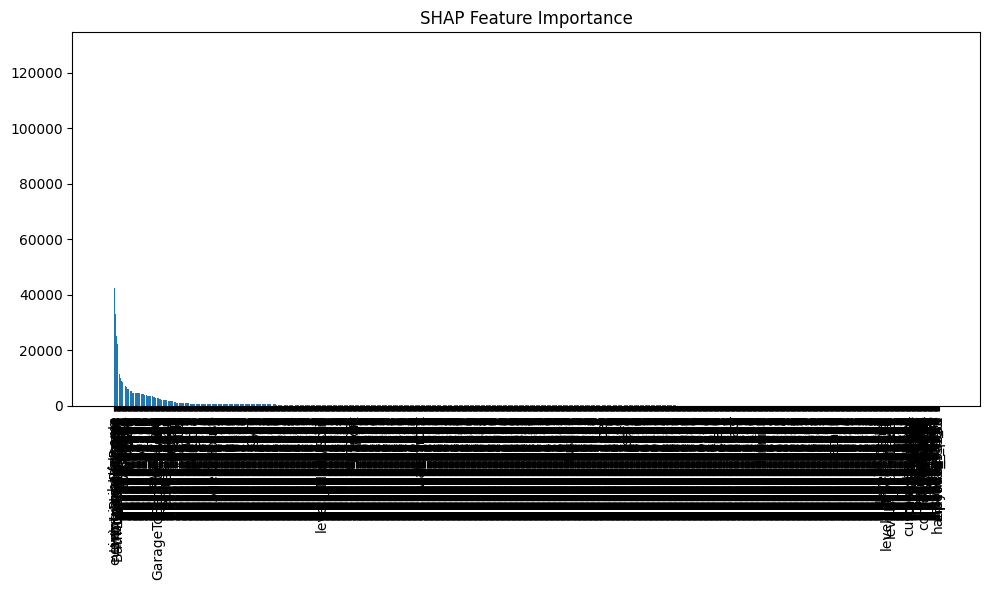

In [18]:
#SHAP feature analysis
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure X_train is a DataFrame with named features
if not isinstance(X_train, pd.DataFrame):
    feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]
    X_train = pd.DataFrame(X_train, columns=feature_names)

# Create a SHAP explainer
explainer = shap.LinearExplainer(best_estimator, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Create a summary plot
shap.summary_plot(shap_values, X_train)

# Get feature importance
feature_importance = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns, feature_importance)), columns=['Feature', 'Importance'])
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)

print("Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=90)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

In [22]:
#print the top 100 values from feature_importance
print(feature_importance.head(60))

                  Feature     Importance
0               bathrooms  128255.662613
1       LivingAreaPerRoom   42365.346779
2   event_Listed_for_sale   39260.450993
3      event_Price_change   33241.332212
4            garageSpaces   31936.837656
5       lotAreaUnits_sqft   25280.075635
6      lotAreaUnits_Acres   25280.075635
7      BathToBedroomRatio   22194.823543
8              event_Sold   20880.771485
9                bedrooms   16931.646762
10          zipcode_94080   11298.405487
11          zipcode_95051   10199.230377
12                   pool    9800.638966
13          zipcode_94941    8995.342775
14                    spa    8736.895138
15          zipcode_94115    8729.692984
16              hasGarage    8517.485399
17          zipcode_93722    8410.873026
18             levels_One    7950.518215
19          zipcode_93611    7559.720136
20          zipcode_92629    7182.591933
21                parking    7098.069472
22          zipcode_95132    7066.271135
23          zipc

#### Linear Regression

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import time
import warnings

# Set the random seed for numpy
np.random.seed(42)

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Select the features for polynomial transformation
poly_features = ['bathrooms', 'bedrooms', 'garageSpaces', 'AgeOfHouse', 'LivingAreaPerRoom', 'BathToBedroomRatio', 'GarageToBedroomRatio']

# Define parameter grid for LinearRegression
linear_regression_params = {
    'fit_intercept': [True, False],
    'n_jobs': [-1]
}

# Separate features and target
X_poly = df_ohe_scaled.drop('price', axis=1)
y_poly = df_ohe_scaled['price']

# Perform train-test split before feature selection
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)

# Perform feature selection
print("Performing feature selection of 100 features using SelectKBest...")
n_features_to_select = 100
selector_poly = SelectKBest(f_regression, k=n_features_to_select)
X_poly_train_selected = selector_poly.fit_transform(X_poly_train, y_poly_train)
selected_feature_mask = selector_poly.get_support()

# Get the names of selected features
selected_feature_names = X_poly.columns[selected_feature_mask].tolist()

# Apply the same feature selection to the test set
X_poly_test_selected = X_poly_test.iloc[:, selected_feature_mask]

# Iterate through polynomial degrees
for degree in range(1, 5):
    print(f"\nTesting polynomial degree: {degree}")
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Apply polynomial transformation to both train and test sets
    poly_features_train = poly.fit_transform(X_poly_train[poly_features])
    poly_features_test = poly.transform(X_poly_test[poly_features])
    
    poly_feature_names = poly.get_feature_names_out(poly_features)
    
    # Combine selected features and polynomia
    # l features for both train and test
    X_poly_train_combined = np.hstack((X_poly_train_selected, poly_features_train))
    X_poly_test_combined = np.hstack((X_poly_test_selected, poly_features_test))
    
    # Create feature names for the combined dataset
    combined_feature_names = selected_feature_names + poly_feature_names.tolist()
    
    # Standardize the features
    scaler_poly = StandardScaler()
    X_poly_train_scaled = scaler_poly.fit_transform(X_poly_train_combined)
    X_poly_test_scaled = scaler_poly.transform(X_poly_test_combined)
    
    # Perform GridSearchCV for hyperparameter tuning
    print("Performing GridSearchCV...")
    grid_search_poly = GridSearchCV(
        LinearRegression(), 
        linear_regression_params, 
        scoring='neg_mean_squared_error', 
        cv=3, 
        n_jobs=-1
    )
    
    # Fit the model and time it
    start_time = time.time()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        grid_search_poly.fit(X_poly_train_scaled, y_poly_train)
    fit_time = time.time() - start_time
    
    # Get the best estimator
    best_estimator = grid_search_poly.best_estimator_
    
    # Make predictions
    y_poly_pred_train = best_estimator.predict(X_poly_train_scaled)
    y_poly_pred_test = best_estimator.predict(X_poly_test_scaled)
    
    # Calculate performance metrics
    rmse_train = np.sqrt(mean_squared_error(y_poly_train, y_poly_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_poly_test, y_poly_pred_test))
    r2_train = r2_score(y_poly_train, y_poly_pred_train)
    r2_test = r2_score(y_poly_test, y_poly_pred_test)
    
    # Store results in the 'results' dictionary
    model_name = f"LinearRegression_Poly{degree}"
    results[model_name] = (best_estimator, rmse_train, rmse_test, r2_train, r2_test, fit_time)
    
    # Print results
    print(f"Model: {model_name}")
    print(f"Best Parameters: {best_estimator.get_params()}")
    print(f"RMSE (Train): {rmse_train:.4f}")
    print(f"R-squared (Train): {r2_train:.4f}")
    print(f"RMSE (Test): {rmse_test:.4f}")
    print(f"R-squared (Test): {r2_test:.4f}")
    print(f"Fit Time: {fit_time:.4f} seconds")
    
    # Update best model if current model is better
    if rmse_test < best_rmse_test:
        best_rmse_test = rmse_test
        best_model = best_estimator

# Print the best polynomial degree
best_poly_degree = min(results, key=lambda k: results[k][2]).split('_')[-1]
print(f"\nBest Polynomial Degree for Linear Regression: {best_poly_degree}")

Performing feature selection of 100 features using SelectKBest...

Testing polynomial degree: 1
Performing GridSearchCV...
Model: LinearRegression_Poly1
Best Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}
RMSE (Train): 341489.3850
R-squared (Train): 0.4831
RMSE (Test): 351379.5082
R-squared (Test): 0.4695
Fit Time: 8.9724 seconds

Testing polynomial degree: 2
Performing GridSearchCV...
Model: LinearRegression_Poly2
Best Parameters: {'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'positive': False}
RMSE (Train): 541458.4975
R-squared (Train): -0.2994
RMSE (Test): 545899.8855
R-squared (Test): -0.2805
Fit Time: 1.9862 seconds

Testing polynomial degree: 3
Performing GridSearchCV...
Model: LinearRegression_Poly3
Best Parameters: {'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'positive': False}
RMSE (Train): 317794.5282
R-squared (Train): 0.5524
RMSE (Test): 344053.3515
R-squared (Test): 0.4914
Fit Time: 1.7184 seconds

Testing polynomia

## Models comparison

In [24]:
from tabulate import tabulate

# Prepare the data for tabulation
table_data = []
for model_name, (best_estimator, rmse_train, rmse_test, r2_train, r2_test, fit_time) in results.items():
    params = best_estimator.get_params() if hasattr(best_estimator, 'get_params') else 'N/A'
    table_data.append([
        model_name,
        f"{rmse_train:.4f}",
        f"{rmse_test:.4f}",
        f"{r2_train:.4f}",
        f"{r2_test:.4f}",
        f"{fit_time:.4f}",
        str(params)
    ])

# Define headers
headers = ["Model", "Training RMSE", "Test RMSE", "R-squared (Train)", "R-squared (Test)", "Fit Time (s)", "Best Parameters"]

# Create and print the table
print("\nModel Evaluation Results:")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

# Print the best model
best_model_name = min(results, key=lambda k: results[k][2])
print(f"\nBest Model: {best_model_name}")
print(f"Best Test RMSE: {results[best_model_name][2]:.4f}")


Model Evaluation Results:
+---------------------------+-----------------+------------------+---------------------+--------------------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Model                     |   Training RMSE |        Test RMSE |   R-squared (Train) |   R-squared (Test) |   Fit Time (s) | Best Parameters                                                                                                                                                                                                                                                       

# Best Model
On the basis of RMSE (Test), R-squared (Test) and Fit time)(seconds), Ridge model has performed better than other regression models.

In [25]:
#print the best_model
print(best_model)

Ridge(alpha=0.5, random_state=42)
